## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import joblib
import seaborn as sns  
from sklearn.metrics import mean_squared_error

In [22]:
df = pd.read_csv('results.csv')

In [27]:
patients = [1, 2, 4, 6, 7, 8]
approaches = ['nollm', 'pixtral-large-latest']
prediction_horizons = [6, 12]
for approach in approaches:
    for prediction_horizon in prediction_horizons:
        all_patients_df = df[(df['Approach'] == approach) & (df['Prediction Horizon'] == prediction_horizon)]
        overall_mean_rmse = round(all_patients_df['RMSE'].mean(), 2)
        overall_rmse_std = round(all_patients_df['RMSE'].std(), 2)
        for patient in patients:
            patients_df = df[(df['Approach'] == approach) & (df['Prediction Horizon'] == prediction_horizon) & (df['Patient'] == patient)]
            patient_mean_rmse = round(patients_df['RMSE'].mean(), 2)
            patient_rmse_std = round(patients_df['RMSE'].std(), 2)
            print(f"Patient {patient} RMSE: {patient_mean_rmse}±{patient_rmse_std}")
        print(f"Overall RMSE: {overall_mean_rmse}±{overall_rmse_std}")
        print("--------------------------------")

Patient 1 RMSE: 14.78±8.71
Patient 2 RMSE: 18.49±11.34
Patient 4 RMSE: 22.55±12.25
Patient 6 RMSE: 12.95±8.09
Patient 7 RMSE: 13.87±16.39
Patient 8 RMSE: 16.76±7.34
Overall RMSE: 16.29±11.19
--------------------------------
Patient 1 RMSE: 31.77±19.86
Patient 2 RMSE: 40.18±24.74
Patient 4 RMSE: 46.16±29.75
Patient 6 RMSE: 25.27±16.07
Patient 7 RMSE: 25.14±23.53
Patient 8 RMSE: 32.2±14.76
Overall RMSE: 32.95±22.64
--------------------------------
Patient 1 RMSE: 14.42±8.78
Patient 2 RMSE: 18.31±11.48
Patient 4 RMSE: 21.88±12.01
Patient 6 RMSE: 12.88±8.31
Patient 7 RMSE: 13.37±15.26
Patient 8 RMSE: 17.1±7.1
Overall RMSE: 16.07±10.94
--------------------------------
Patient 1 RMSE: 29.83±18.97
Patient 2 RMSE: 39.09±24.05
Patient 4 RMSE: 43.68±26.58
Patient 6 RMSE: 24.95±16.53
Patient 7 RMSE: 23.81±21.7
Patient 8 RMSE: 33.21±14.65
Overall RMSE: 31.96±21.45
--------------------------------


In [29]:
def create_rmse_latex_table(df, output_file='latex_tables/rmse_comparison.tex'):
    """
    Create a LaTeX table comparing RMSE values between approaches.
    
    Args:
        df: DataFrame with columns 'Approach', 'Prediction Horizon', 'Patient', 'RMSE'
        output_file: Path to save the LaTeX table
    """
    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Define approaches, patients, and prediction horizons
    approaches = ['nollm', 'pixtral-large-latest']
    display_names = {'pixtral-large-latest': 'Pixtral', 'nollm': 'NoLLM'}
    patients = [1, 2, 4, 6, 7, 8]
    prediction_horizons = [6, 12]
    
    # Table header
    latex_lines = [
        "\\begin{table}%[h]",
        "\\caption{Comparison of RMSE Values Between Pixtral and NoLLM Approaches}",
        "\\label{tab:rmse_comparison}",
        "\\renewcommand{\\arraystretch}{1.3}",
        "\\begin{tabular}{|l|cc|cc|}",
        "\\hline",
        "\\rowcolor{gray!20} \\textbf{Patient} & \\multicolumn{2}{c|}{\\textbf{PH 30}} & \\multicolumn{2}{c|}{\\textbf{PH 60}} \\\\",
        f"\\rowcolor{{gray!20}} & \\textbf{{{display_names[approaches[0]]}}} & \\textbf{{{display_names[approaches[1]]}}} & \\textbf{{{display_names[approaches[0]]}}} & \\textbf{{{display_names[approaches[1]]}}} \\\\",
        "\\hline"
    ]
    
    # Store values for each cell in the table
    patient_values = {}
    overall_values = {}
    
    # First pass: calculate all the values
    for approach in approaches:
        for prediction_horizon in prediction_horizons:
            # Get all data for this approach and prediction horizon
            all_patients_df = df[(df['Approach'] == approach) & (df['Prediction Horizon'] == prediction_horizon)]
            
            # Calculate overall stats across all measurements
            overall_mean_rmse = round(all_patients_df['RMSE'].mean(), 2)
            overall_rmse_std = round(all_patients_df['RMSE'].std(), 2)
            
            # Save overall stats
            overall_values[(approach, prediction_horizon)] = (overall_mean_rmse, overall_rmse_std)
            
            # Calculate per-patient stats
            for patient in patients:
                patients_df = df[(df['Approach'] == approach) & 
                                (df['Prediction Horizon'] == prediction_horizon) & 
                                (df['Patient'] == patient)]
                
                patient_mean_rmse = round(patients_df['RMSE'].mean(), 2)
                patient_rmse_std = round(patients_df['RMSE'].std(), 2)
                
                # Save patient stats
                patient_values[(patient, approach, prediction_horizon)] = (patient_mean_rmse, patient_rmse_std)
    
    # Second pass: create the table
    for i, patient in enumerate(patients):
        # Add gray background to alternate rows
        if i % 2 == 0:
            latex_lines.append("\\rowcolor{gray!10}")
        
        row_values = [f"\\textbf{{{patient}}}"]
        
        # Add data for each prediction horizon and approach
        for ph in prediction_horizons:
            for approach in approaches:
                mean_rmse, std_rmse = patient_values[(patient, approach, ph)]
                row_values.append(f"{mean_rmse:0.2f}$\\pm${std_rmse:0.2f}")
        
        # Complete the row
        latex_lines.append(" & ".join(row_values) + " \\\\")
        latex_lines.append("\\hline")
    
    # Add the overall mean ± std row
    latex_lines.append("\\rowcolor{gray!20}")
    overall_row = ["\\textbf{Mean $\\pm$ STD}"]
    
    for ph in prediction_horizons:
        for approach in approaches:
            mean_rmse, std_rmse = overall_values[(approach, ph)]
            overall_row.append(f"{mean_rmse:0.2f}$\\pm${std_rmse:0.2f}")
    
    latex_lines.append(" & ".join(overall_row) + " \\\\")
    latex_lines.append("\\hline")
    
    # Close the table
    latex_lines.extend([
        "\\end{tabular}",
        "\\end{table}"
    ])
    
    # Join and write to file
    latex_content = "\n".join(latex_lines)
    with open(output_file, 'w') as f:
        f.write(latex_content)
    
    print(f"LaTeX table saved to {output_file}")
    return latex_content

# Example usage:
create_rmse_latex_table(df, 'latex_tables/rmse_comparison.tex')

LaTeX table saved to latex_tables/rmse_comparison.tex


'\\begin{table}%[h]\n\\caption{Comparison of RMSE Values Between Pixtral and NoLLM Approaches}\n\\label{tab:rmse_comparison}\n\\renewcommand{\\arraystretch}{1.3}\n\\begin{tabular}{|l|cc|cc|}\n\\hline\n\\rowcolor{gray!20} \\textbf{Patient} & \\multicolumn{2}{c|}{\\textbf{PH 30}} & \\multicolumn{2}{c|}{\\textbf{PH 60}} \\\\\n\\rowcolor{gray!20} & \\textbf{NoLLM} & \\textbf{Pixtral} & \\textbf{NoLLM} & \\textbf{Pixtral} \\\\\n\\hline\n\\rowcolor{gray!10}\n\\textbf{1} & 14.78$\\pm$8.71 & 14.42$\\pm$8.78 & 31.77$\\pm$19.86 & 29.83$\\pm$18.97 \\\\\n\\hline\n\\textbf{2} & 18.49$\\pm$11.34 & 18.31$\\pm$11.48 & 40.18$\\pm$24.74 & 39.09$\\pm$24.05 \\\\\n\\hline\n\\rowcolor{gray!10}\n\\textbf{4} & 22.55$\\pm$12.25 & 21.88$\\pm$12.01 & 46.16$\\pm$29.75 & 43.68$\\pm$26.58 \\\\\n\\hline\n\\textbf{6} & 12.95$\\pm$8.09 & 12.88$\\pm$8.31 & 25.27$\\pm$16.07 & 24.95$\\pm$16.53 \\\\\n\\hline\n\\rowcolor{gray!10}\n\\textbf{7} & 13.87$\\pm$16.39 & 13.37$\\pm$15.26 & 25.14$\\pm$23.53 & 23.81$\\pm$21.70 \\\\\

## Investigate performance differences between patients

In [131]:
def find_patients_with_lowest_rmse(df, ph):
    df = df[df['Prediction Horizon']==ph]
    pivot_df = df.pivot(index='Patient', columns='Approach', values='RMSE')
    
    # Find patients where "nollm" has the lowest RMSE
    patients_with_lowest_rmse = pivot_df.idxmin(axis=1)
    return patients_with_lowest_rmse[patients_with_lowest_rmse == 'nollm'].index.tolist()

for ph in [6, 12]:
    patients_with_lowest_rmse = find_patients_with_lowest_rmse(results, ph)
    print(f"Patients where 'nollm' has the lowest RMSE at PH {ph}:", patients_with_lowest_rmse)

Patients where 'nollm' has the lowest RMSE at PH 6: [2, 8]
Patients where 'nollm' has the lowest RMSE at PH 12: [2, 6, 8]


## Investigate whether glucose and food data differ between patients

In [132]:
def plot_timeline_with_predictions(ground_truth, datetime, y_preds, approaches):  

    # Combining dataframes
    data_ground_truth = pd.DataFrame({  
        'Datetime': datetime,  
        'Glucose Level': ground_truth,  
        'Type': 'Ground Truth'  
    })  
    all_data_predictions = []  
    for approach in approaches:  
        data_predictions = pd.DataFrame({  
            'Datetime': datetime,  
            'Glucose Level': y_preds[approach],  
            'Type': f'Prediction {approach}'  
        })  
        all_data_predictions.append(data_predictions)  
    data_combined = pd.concat([data_ground_truth] + all_data_predictions, ignore_index=True)  
    data_combined['Datetime'] = pd.to_datetime(data_combined['Datetime'])  
    data_combined['Time'] = data_combined['Datetime'].dt.strftime('%H:%M')  
      
    # Plotting  
    sns.set_theme(style="whitegrid")  
    plt.figure(figsize=(12, 6))  
    sns.lineplot(data=data_combined[data_combined['Type'] == 'Ground Truth'],  
                 x='Time',  
                 y='Glucose Level',  
                 label='Ground Truth',  
                 color='#1f77b4',  
                 alpha=1.0)  
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  
    for i, approach in enumerate(approaches):  
        sns.lineplot(data=data_combined[data_combined['Type'] == f'Prediction {approach}'],  
                     x='Time',  
                     y='Glucose Level',  
                     label=f'Prediction {approach}',  
                     color=colors[i],  
                     alpha=0.7)  
      
    plt.xlabel("Time", fontsize=12)  
    plt.ylabel("Glucose Level (mg/dL)", fontsize=12)  
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.legend(fontsize=10)  
      
    # Adjusting x-axis tick frequency  
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  
      
    plt.tight_layout()  
    plt.show()  

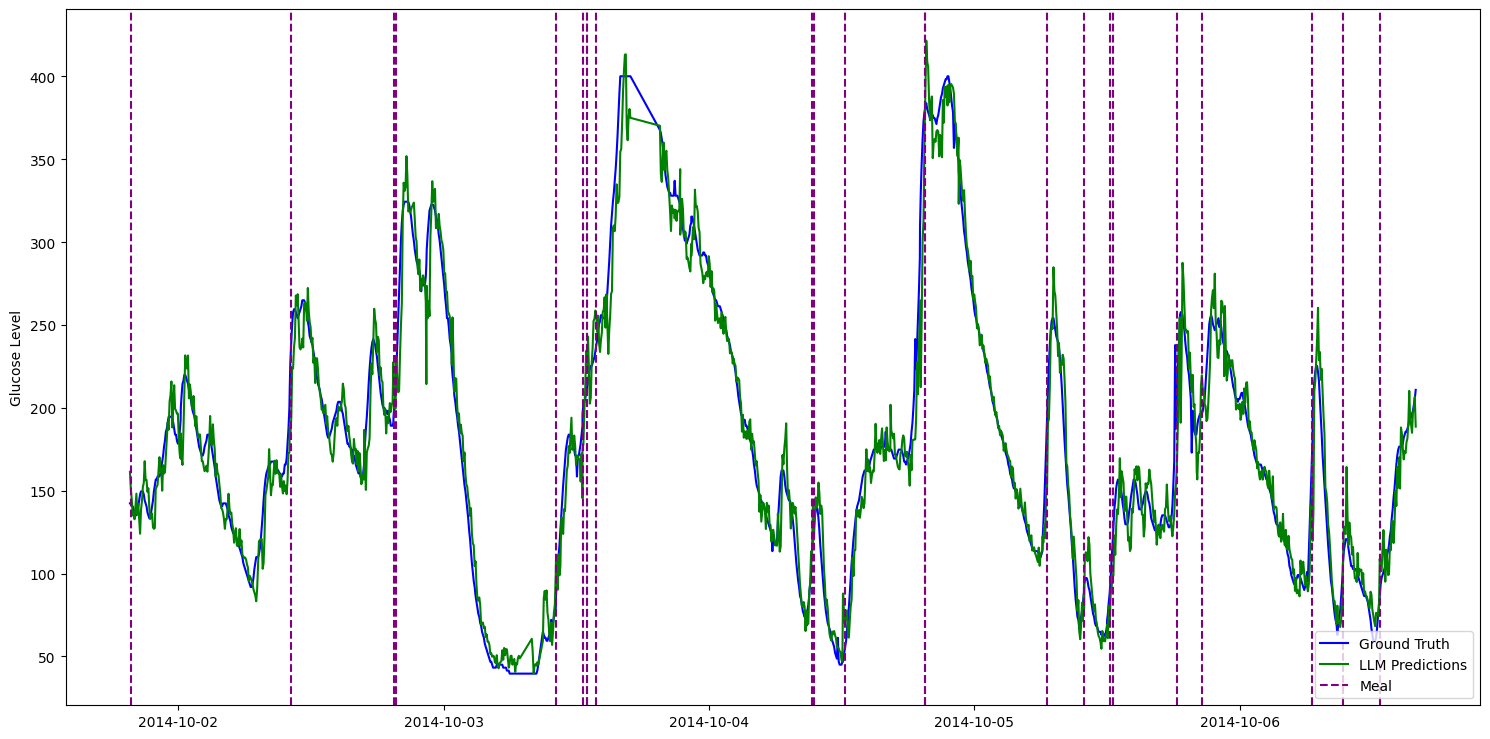

All plots have been saved as PNG files.


In [18]:
patient = '001'
prediction_horizon = 6
approaches = ['gpt4o', 'nollm']


food_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

insulin_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
insulin_data['datetime'] = pd.to_datetime(insulin_data['datetime'], format='%Y:%m:%d %H:%M:%S')

approach = 'nollm'
nollm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")
approach = 'gpt4o'
llm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")

start_idx = 0
end_idx = len(llm_preds)
selected_idx = list(range(start_idx, end_idx))
llm_preds = llm_preds.iloc[selected_idx, :]
nollm_preds = nollm_preds.iloc[selected_idx, :]

nollm_preds['Datetime'] = pd.to_datetime(nollm_preds['Datetime'])

plt.figure(figsize=(15, 7.5))

# Plot Ground Truth
plt.plot(nollm_preds['Datetime'], nollm_preds['Ground_truth'], label='Ground Truth', color='blue')

# Plot Predictions
plt.plot(nollm_preds['Datetime'], llm_preds['Predictions'], label='LLM Predictions', color='green')

# Plot Predictions
#plt.plot(nollm_preds['Datetime'], nollm_preds['Predictions'], label='NoLLM Predictions', color='red')

# Add vertical lines for meal times
for idx, meal_time in food_data.iterrows():
    if nollm_preds['Datetime'].iloc[0] <= meal_time['datetime'] <= nollm_preds['Datetime'].iloc[-1]:
        plt.axvline(x=meal_time['datetime'], color='purple', linestyle='--')

# Add dummy plots to include in the legend
plt.plot([], [], color='purple', linestyle='--', label='Meal')


rmse_no_llm = round(np.sqrt(mean_squared_error(nollm_preds['Ground_truth'], nollm_preds['Predictions'])), 2)
rmse_llm = round(np.sqrt(mean_squared_error(llm_preds['Ground_truth'], llm_preds['Predictions'])), 2)

plt.ylabel('Glucose Level')
plt.legend(loc='lower right')
#plt.title(f'Patient {patient} at PH {prediction_horizon*5} minutes\nRMSE LLM (Hypo): {rmse_llm}, RMSE No LLM (Hypo): {rmse_no_llm}')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig(f'paper_images/patient_{patient}_predictions.png', dpi=300, bbox_inches='tight')
plt.show() # Close the figure to free up memory

print("All plots have been saved as PNG files.")

In [134]:
nollm_preds

,Predictions,Ground_truth,Datetime
0,158.858515,142.34378,2014-10-01 19:39:00
1,152.510527,142.34378,2014-10-01 19:44:00
2,146.046538,140.54196,2014-10-01 19:49:00
3,136.960102,140.54196,2014-10-01 19:54:00
4,140.178984,138.74014,2014-10-01 19:59:00
...,...,...,...
1366,182.276671,196.39838,2014-10-06 15:34:02
1367,197.490722,198.20020,2014-10-06 15:39:02
1368,200.688282,201.80384,2014-10-06 15:44:02
1369,210.508417,205.40748,2014-10-06 15:49:02


## Investigate global feature importances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


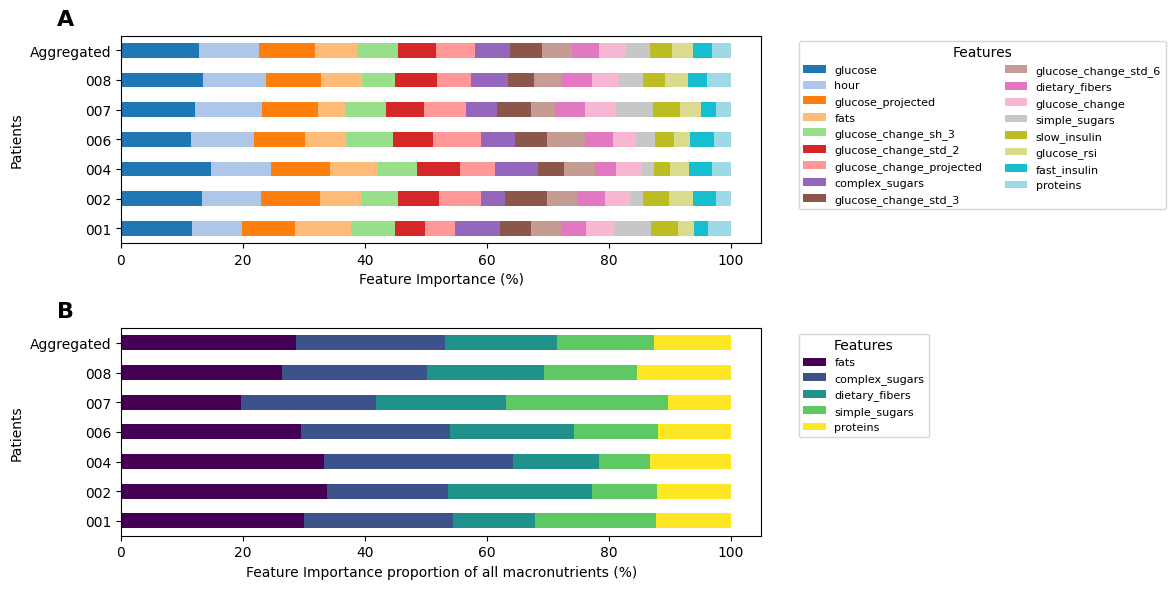

In [139]:
prediction_horizon = 6
model_path = f"models/gpt4o/{prediction_horizon}_1_{patient}.joblib"
model = joblib.load(model_path)
importances_df = pd.DataFrame(index=model.feature_name_)

patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    model_path = f"models/gpt4o/{prediction_horizon}_1_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Normalize importances
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
importances_df['Aggregated'] = importances_df.mean(axis=1)
importances_df = importances_df.sort_values(by='Aggregated', ascending=False)

# Prepare data for the second plot
combined_importances = pd.DataFrame()
features_of_interest = ['dietary_fibers', 'simple_sugars', 'fats', 'complex_sugars', 'proteins']

for feature in features_of_interest:
    combined_importances[feature] = importances_df.loc[feature]

combined_importances = combined_importances.transpose()
combined_importances['Aggregated'] = combined_importances.sum(axis=1)
combined_importances = combined_importances.sort_values(by='Aggregated', ascending=False)

normalized_importances = combined_importances.div(combined_importances.sum(axis=0), axis=1) * 100

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# First plot
importances_df.T.plot(kind='barh', stacked=True, colormap='tab20', ax=axes[0])
axes[0].set_xlabel('Feature Importance (%)')
axes[0].set_ylabel('Patients')
axes[0].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold')

# Second plot
normalized_importances.T.plot(kind='barh', stacked=True, colormap='viridis', ax=axes[1])
axes[1].set_xlabel('Feature Importance proportion of all macronutrients (%)')
axes[1].set_ylabel('Patients')
axes[1].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold')

plt.savefig(f'paper_images/feature_importances_{approach}.eps', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [142]:
# Calculate total importance of meal features
meal_features = ['fats', 'dietary_fibers', 'simple_sugars', 'complex_sugars', 'proteins']
meal_importances = importances_df.loc[meal_features]
total_meal_importance = meal_importances.sum()

print("Total percentage of meal features importance:")
print(f"{total_meal_importance}")
print(f"Average across patients: {total_meal_importance['Aggregated']:.2f}%")

Total percentage of meal features importance:
001           30.391367
002           20.037807
004           23.193577
006           22.792289
007           22.797767
008           25.726208
Aggregated    24.156502
dtype: float64
Average across patients: 24.16%


In [141]:
importances_df.drop(['glucose', 'glucose_projected', 'glucose_change_projected', 'glucose_change_std_2', 'glucose_change_std_3', 'glucose_change_std_6', 'glucose_change_sh_3', 'slow_insulin', 'fast_insulin', 'glucose_rsi', 'glucose_change', 'hour'])

,001,002,004,006,007,008,Aggregated
fats,9.131905,6.758034,7.738626,6.716418,4.482010,6.788637,6.935938
complex_sugars,7.424706,4.001260,7.158787,5.597015,5.040323,6.114588,5.889446
dietary_fibers,4.090836,4.725898,3.300624,4.617537,4.885236,4.943027,4.427193
simple_sugars,6.007409,2.142407,1.917930,3.125000,6.032878,3.915904,3.856921
proteins,3.736512,2.410208,3.077609,2.736318,2.357320,3.964051,3.047003


In [31]:
normalized_importances

,001,002,004,006,007,008,Aggregated
fats,26.094891,25.210084,32.971014,29.831144,22.375691,25.365854,26.832838
complex_sugars,24.452555,22.689076,31.159420,23.076923,26.243094,25.365854,25.615704
dietary_fibers,13.138686,28.151261,22.101449,19.887430,25.690608,21.951220,21.725675
proteins,16.605839,9.453782,10.869565,12.945591,12.983425,14.634146,13.036446
simple_sugars,19.708029,14.495798,2.898551,14.258912,12.707182,12.682927,12.789338


In [32]:
highest_macronutrient_per_column = normalized_importances.idxmax()  
highest_macronutrient_per_column  

001                     fats
002           dietary_fibers
004                     fats
006                     fats
007           complex_sugars
008                     fats
Aggregated              fats
dtype: object

## Change in feature importances over different prediction horizons

In [36]:
model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
model = joblib.load(model_path)
importances_df = pd.DataFrame(index=model.feature_name_)

patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Normalize importances
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
importance_sums = importances_df.sum(axis=1)
repeated_elements = [item for item in importance_sums.index for _ in range(3)]


ph_importances_df = pd.DataFrame({'PH': [6, 9, 12]*len(importance_sums), 'Feature': repeated_elements, 'Importance': 0.0, 'SD': 0.0})
for prediction_horizon in ['6', '9', '12']:
    model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df = pd.DataFrame(index=model.feature_name_)

    patients = ['001', '002', '004', '006', '007', '008']
    for patient in patients:
        model_path = f"models/gpt4o/{prediction_horizon}/1_{patient}.joblib"
        model = joblib.load(model_path)
        importances_df[patient] = model.feature_importances_

    # Normalize importances
    importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
    importance_means = importances_df.mean(axis=1)
    importance_stds = importances_df.std(axis=1)
    for feature in importance_means.index:
        ph_importances_df.loc[(ph_importances_df['PH']==int(prediction_horizon)) & (ph_importances_df['Feature']==feature), 'Importance'] = importance_means[feature]
        ph_importances_df.loc[(ph_importances_df['PH']==int(prediction_horizon)) & (ph_importances_df['Feature']==feature), 'SD'] = importance_stds[feature]

In [38]:
highest_phs = []
for feature in ph_importances_df.Feature.unique():
    selected_df = ph_importances_df[ph_importances_df['Feature']==feature]
    highest_ph = selected_df.loc[selected_df['Importance']==selected_df['Importance'].max(), 'PH'].values[0]
    highest_phs.append(highest_ph)

feature_most_impact_ph_df = pd.DataFrame({'Feature': ph_importances_df.Feature.unique(), 'PH': highest_phs})

In [39]:
ph_importances_df

,PH,Feature,Importance,SD
0,30,glucose,11.536643,1.711181
1,45,glucose,12.349173,1.467353
2,60,glucose,12.358188,1.151992
3,30,hour,9.027160,0.604711
4,45,hour,11.138057,1.471997
5,60,hour,11.103670,1.087505
6,30,glucose_change,5.961834,0.670087
7,45,glucose_change,4.788401,1.721601
8,60,glucose_change,4.082319,0.559551
9,30,glucose_change_6,2.845830,1.127200


In [40]:
for ph in [6, 9, 12]:
    features_at_ph = feature_most_impact_ph_df.loc[feature_most_impact_ph_df['PH']==ph, 'Feature'].values
    print(f'Features that have highest impact at PH {ph*5}: {features_at_ph}')

Features that have highest impact at PH 30: []
Features that have highest impact at PH 45: []
Features that have highest impact at PH 60: []


## Visualize feature mapping over time 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


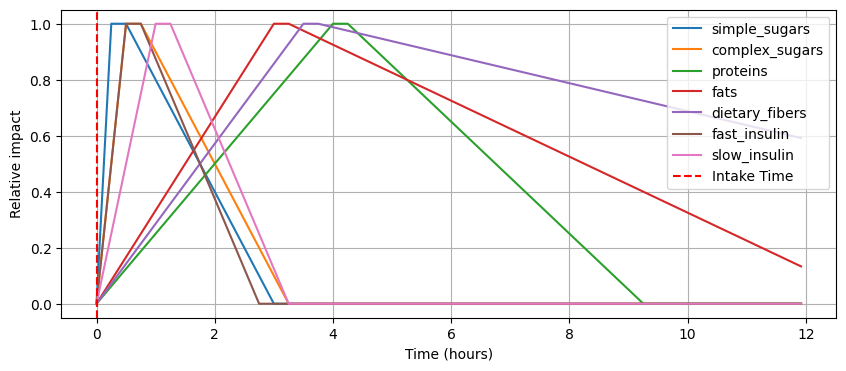

In [20]:
feature_params = {
    'simple_sugars': [0.4, 0.25], 
    'complex_sugars': [0.4, 0.5], 
    'proteins': [0.2, 4], 
    'fats': [0.1, 3], 
    'dietary_fibers': [0.05, 3.5], 
    'fast_insulin': [0.5, 0.5], 
    'slow_insulin': [0.5, 1]
}

times = np.arange(0, 12, (1/12))
intake_time = 0

glucose_data = pd.DataFrame({'Time': times})

for feature, param in feature_params.items():
    time_diff_hours = times - intake_time
    metabolism_rate, peak_time = param[0], param[1]
    plateau_duration = 0.25
    
    weights = np.zeros_like(time_diff_hours)

    # Linear increase (before the peak)
    increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
    weights[increase_mask] = time_diff_hours[increase_mask] / peak_time

    # Plateau (at the peak)
    plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
    weights[plateau_mask] = 1

    # Linear decrease (after the plateau)
    decrease_mask = (time_diff_hours >= peak_time + plateau_duration)
    weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration))*metabolism_rate
    weights = np.clip(weights, 0, np.inf) 
    glucose_data[feature] = weights

plt.figure(figsize=(10, 4))
for feature in feature_params.keys():
    plt.plot(glucose_data['Time'], glucose_data[feature], linestyle='-', label=feature)

plt.axvline(x=intake_time, color='r', linestyle='--', label='Intake Time')
plt.xlabel('Time (hours)')
plt.ylabel('Relative impact')
plt.legend(loc='upper right')
plt.grid(True)

# Save with legend embedded in the EPS file
plt.savefig('paper_images/feature_mapping.eps', dpi=300, bbox_inches='tight')
plt.show()

## Differences in macronutrient estimation between LLMs

In [32]:
approach = 'gpt4o'
prediction_horizon = 6
patient = '004'
preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")
preds.drop('Datetime', axis=1, inplace=True)

In [44]:
import pandas as pd
from glob import glob
from sklearn.metrics import roc_auc_score, accuracy_score

hypo_threshold = 70
hyper_threshold = 180

prediction_files = glob('predictions/*/*/*_predictions.csv')
results = []

In [57]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

# Define glucose level thresholds
hypo_threshold = 70
hyper_threshold = 180

# Approaches and patients to process
approaches = ['gpt4o', 'nollm']
patients = ['001', '002', '004', '006', '007', '008']
prediction_horizon = 6  # Adjust this if needed

# Initialize a list to store results
results = []

for approach in approaches:
    auc_hyper_list = []
    auc_hypo_list = []
    acc_list = []

    for patient in patients:
        # Read predictions
        preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")
    
        # Get the predicted and ground truth glucose levels
        y_true = preds['Ground_truth']
        y_pred = preds['Predictions']
    
        # Create binary labels for hyperglycemia
        y_true_hyper = (y_true > hyper_threshold).astype(int)
    
        # Create binary labels for hypoglycemia
        y_true_hypo = (y_true < hypo_threshold).astype(int)
    
        # Compute AUC for hyperglycemia
        auc_hyper = roc_auc_score(y_true_hyper, y_pred)
    
        # Compute AUC for hypoglycemia (invert predictions for hypoglycemia)
        auc_hypo = roc_auc_score(y_true_hypo, -y_pred)
    
        # Multiclass classification
        y_true_multiclass = []
        y_pred_multiclass = []
    
        for gt, pred in zip(y_true, y_pred):
            # Ground truth classification
            if gt < hypo_threshold:
                y_true_multiclass.append('Hypoglycemia')
            elif gt > hyper_threshold:
                y_true_multiclass.append('Hyperglycemia')
            else:
                y_true_multiclass.append('Euglycemia')
    
            # Prediction classification
            if pred < hypo_threshold:
                y_pred_multiclass.append('Hypoglycemia')
            elif pred > hyper_threshold:
                y_pred_multiclass.append('Hyperglycemia')
            else:
                y_pred_multiclass.append('Euglycemia')
    
        # Compute multiclass accuracy
        multiclass_accuracy = accuracy_score(y_true_multiclass, y_pred_multiclass)
    
        # Compute per-patient standard deviations
        auc_hyper_std = np.std(y_pred[y_true_hyper == 1])
        auc_hypo_std = np.std(-y_pred[y_true_hypo == 1])
        acc_std = np.std([1 if t == p else 0 for t, p in zip(y_true_multiclass, y_pred_multiclass)])
    
        # Append per-patient results with standard deviation
        results.append({
            'Approach': approach,
            'Patient': patient,
            'AUC_Hyperglycemia': f"{auc_hyper:.3f}±{auc_hyper_std:.2f}",
            'AUC_Hypoglycemia': f"{auc_hypo:.3f}±{auc_hypo_std:.2f}",
            'Multiclass_Accuracy': f"{multiclass_accuracy:.3f}±{acc_std:.2f}"
        })
        
        # Collect metrics for overall mean and std
        auc_hyper_list.append(auc_hyper)
        auc_hypo_list.append(auc_hypo)
        acc_list.append(multiclass_accuracy)
    
    # Calculate overall mean and std for the current approach
    mean_auc_hyper = np.mean(auc_hyper_list)
    std_auc_hyper = np.std(auc_hyper_list)
    mean_auc_hypo = np.mean(auc_hypo_list)
    std_auc_hypo = np.std(auc_hypo_list)
    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)
    
    # Append overall mean±std to results
    results.append({
        'Approach': approach,
        'Patient': 'Mean±Std',
        'AUC_Hyperglycemia': f"{mean_auc_hyper:.3f}±{std_auc_hyper:.2f}",
        'AUC_Hypoglycemia': f"{mean_auc_hypo:.3f}±{std_auc_hypo:.2f}",
        'Multiclass_Accuracy': f"{mean_acc:.3f}±{std_acc:.2f}"
    })

# Create DataFrame with results
results_df = pd.DataFrame(results)

In [58]:
# Split results by approach
gpt4o_results = results_df[results_df['Approach'] == 'gpt4o']
nollm_results = results_df[results_df['Approach'] == 'nollm']

# Function to generate LaTeX table for an approach
def generate_latex_table(approach_results, approach_name):
    latex_lines = [
        r'\begin{table}[h!]',
        r'\centering',
        fr'\caption{{Metrics for {approach_name} Approach}}',
        fr'\label{{tab:metrics_{approach_name}}}',
        r'\renewcommand{\arraystretch}{1.2}',
        r'\begin{tabular}{|c|c|c|c|}',
        r'\hline',
        r'\rowcolor{gray!20} \textbf{Patient} & \textbf{AUC Hyperglycemia} & \textbf{AUC Hypoglycemia} & \textbf{Multiclass Accuracy} \\',
        r'\hline'
    ]

    # Add patient rows
    for index, row in approach_results.iterrows():
        latex_lines.append(f"{row['Patient']} & {row['AUC_Hyperglycemia']} & {row['AUC_Hypoglycemia']} & {row['Multiclass_Accuracy']} \\\\")
        latex_lines.append(r'\hline')

    latex_lines.extend([
        r'\end{tabular}',
        r'\end{table}'
    ])

    # Combine all lines into a single string
    latex_content = '\n'.join(latex_lines)

    # Save LaTeX content to file
    with open(f'latex_tables/metrics_table_{approach_name}.tex', 'w') as f:
        f.write(latex_content)

# Generate tables for both approaches
generate_latex_table(gpt4o_results, 'GPT4O')
generate_latex_table(nollm_results, 'NoLLM')